In [8]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("nycflights") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

In [3]:
from nycflights13 import flights as flights_pd

In [4]:
flights = spark.createDataFrame(flights_pd)

In [19]:
flights.persist()

DataFrame[year: bigint, month: bigint, day: bigint, dep_time: double, sched_dep_time: bigint, dep_delay: double, arr_time: double, sched_arr_time: bigint, arr_delay: double, carrier: string, flight: bigint, tailnum: string, origin: string, dest: string, air_time: double, distance: bigint, hour: bigint, minute: bigint, time_hour: string]

In [26]:
col_df = flights[["distance"]]

In [31]:
limits = col_df.agg(F.min("distance"), F.max("distance")).collect()

In [35]:
min_, max_ = limits[0][0], limits[0][1]

In [36]:
min_, max_

(17, 4983)

In [74]:
bins = 30

In [75]:
binwidth = (max_ - min_) / (bins)

In [76]:
buckets = [min_ + i * binwidth for i in range(bins + 1)]

In [77]:
from pyspark.ml.feature import Bucketizer

In [78]:
bucketizer = Bucketizer(splits=buckets, inputCol="distance", outputCol="bucket")
buckets_df = bucketizer.setHandleInvalid("keep").transform(col_df)

In [91]:
histogram = buckets_df.groupby("bucket").agg(F.count("distance").alias("count"))

In [92]:
histogram = histogram.orderBy("bucket", ascending=True)

In [93]:
histogram.show()

+------+-----+
|bucket|count|
+------+-----+
|   0.0| 3657|
|   1.0|54139|
|   2.0|28737|
|   3.0|28455|
|   4.0|51842|
|   5.0|30350|
|   6.0|45510|
|   7.0| 3322|
|   8.0|19019|
|   9.0|17025|
|  10.0|  497|
|  11.0| 2528|
|  12.0| 4656|
|  13.0| 5997|
|  14.0|26071|
|  15.0|14256|
|  20.0|    8|
|  29.0|  707|
+------+-----+



In [94]:
col_rows = histogram.select("count").collect()

In [95]:
weights = [row[0] for row in col_rows]

In [96]:
weights

[3657,
 54139,
 28737,
 28455,
 51842,
 30350,
 45510,
 3322,
 19019,
 17025,
 497,
 2528,
 4656,
 5997,
 26071,
 14256,
 8,
 707]

In [99]:
x = np.linspace(buckets[0], buckets[-1], len(weights))

<BarContainer object of 18 artists>

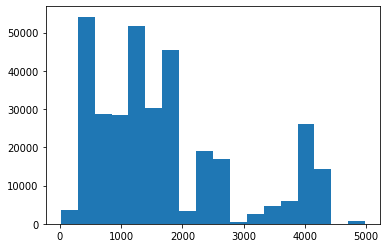

In [102]:
_, _, p = plt.hist(x, len(x), weights=weights)
p

In [104]:
with plt.style.context():
    p

TypeError: context() got an unexpected keyword argument 'style_label'